# 准备数据

In [1]:
# 准备数据集
!wget https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd009/MLND+Capstone/Mathematical_Expression_Recognition_train.zip
!unzip -q Mathematical_Expression_Recognition_train.zip
!ls

--2019-03-10 10:17:40--  https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd009/MLND+Capstone/Mathematical_Expression_Recognition_train.zip
Resolving s3.cn-north-1.amazonaws.com.cn (s3.cn-north-1.amazonaws.com.cn)... 54.222.49.93
Connecting to s3.cn-north-1.amazonaws.com.cn (s3.cn-north-1.amazonaws.com.cn)|54.222.49.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328117062 (313M) [application/zip]
Saving to: ‘Mathematical_Expression_Recognition_train.zip’

Mathematical_Expres 100%[===================>] 312.92M  53.5MB/s    in 6.3s    

2019-03-10 10:17:52 (49.8 MB/s) - ‘Mathematical_Expression_Recognition_train.zip’ saved [328117062/328117062]

Mathematical_Expression_Recognition_train.zip  sample_data  train  train.csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

!pip install livelossplot -q

In [3]:
labels_data = pd.read_csv('./train.csv')

labels_data.head()

,filename,label
0,train/0.jpg,(0+0)+9=9
1,train/1.jpg,9*8+6=78
2,train/2.jpg,1+7+0=8
3,train/3.jpg,5+4+9=18
4,train/4.jpg,7-(1*7)=0


In [4]:
labels_data.label.str.len().max()

11

In [0]:
def show_imgs(imgs, titles, col=1):
    fig = plt.figure()
    rows = len(imgs)//col+1
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(rows, col, i+1)
        ax.imshow(img)
        ax.set(title=titles[i])
    fig.show()

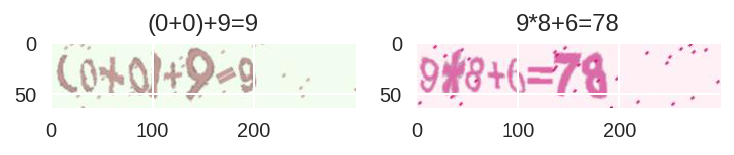

In [6]:
imgs = []
titles = []
imgs.append(plt.imread(labels_data['filename'][0]))
imgs.append(plt.imread(labels_data['filename'][1]))

titles.append(labels_data['label'][0])
titles.append(labels_data['label'][1])

show_imgs(imgs, titles, 2)

## 预处理

### 1. 灰度化

In [0]:
def convert_rgb_to_grayscale(img):
    return 0.21 * img[:, :, :1] + 0.72 * img[:, :, 1:2] + 0.07 * img[:, :, -1:]

In [0]:
img0 = convert_rgb_to_grayscale(plt.imread('train/0.jpg'))

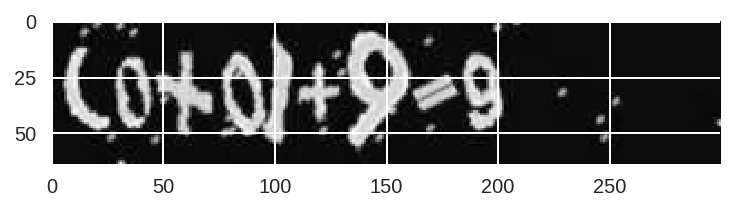

In [9]:
plt.imshow(img0[:, :, 0])

## 2. 归一化

### 学习循环神经网络

1. LSTM的计算方法：https://colah.github.io/posts/2015-08-Understanding-LSTMs/
2. RCNN计算过程：http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
 
 The idea behind RNNs is to **make use of sequential information.** In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far. In theory RNNs can make use of information in arbitrarily long sequences, but in practice they are limited to looking back only a few steps (more on this later).
 ![替代文字](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)
 
 与传统的深度神经网络不同的地方：
 - You can think of the hidden state $s_t$ as the memory of the network. $s_t$ captures information about what happened in all the previous time steps. The output at step o_t is calculated solely based on the memory at time t. As briefly mentioned above, it’s a bit more complicated  in practice because s_t typically can’t capture information from too many time steps ago.
 - Unlike a traditional deep neural network, which uses different parameters at each layer, **a RNN shares the same parameters (U, V, W above) across all steps.** This reflects the fact that we are performing the same task at each step, just with different inputs. This greatly reduces the total number of parameters we need to learn.
 - The above diagram has outputs at each time step, but depending on the task this may not be necessary. For example, when predicting the sentiment of a sentence we may only care about the final output, not the sentiment after each word. Similarly, we may not need inputs at each time step. The main feature of an RNN is its hidden state, which captures some information about a sequence.

# 搭建模型

### 配置信息

In [0]:
import cv2
import matplotlib.pyplot as plt

# Configuration
characters = '-+*()=0123456789'
num_of_chars = len(characters) + 1

characters_list = [char for char in characters]
characters_list.append(' ')

max_text_len = 17
img_width = 64
img_height = 300
img_channel = 1
time_steps = 19

batch_size = 100
valid_batch_size = 100

predict_valid_batch_size = 100

epoch_n = 30


def text_to_index(text):
    return [characters_list.index(char) for char in text]


def index_to_text(index):
    return [characters_list[i] for i in index]


### 数据生成

In [0]:
class DataGenerator:
    def __init__(self, img_paths, labels, img_w, img_h, img_channels, max_label_length, batch_size, shuffle=True):
        self.img_paths = img_paths
        self.labels = labels
        self.img_width = img_w
        self.img_height = img_h
        self.img_channels = img_channels
        self.max_label_length = max_label_length
        self.num_of_samples = len(img_paths)
        self.cur_index = 0
        self.indexes = list(range(self.num_of_samples))
        self.batch_size = batch_size
        self.shuffle = shuffle

    def next_sample(self):
        if self.cur_index >= self.num_of_samples:
            if self.shuffle:
                np.random.shuffle(self.indexes)
            self.cur_index = 0
        img_path_idx = self.indexes[self.cur_index]
        img = cv2.imread(self.img_paths[img_path_idx], cv2.IMREAD_GRAYSCALE)  # (w, h)
        img = img / 255 * 2 - 1  # 归一化，中心化
        img = np.expand_dims(img, axis=2)[None, :]  # (bs, w, h, ch)
        label_str = self.labels[self.indexes[self.cur_index]]
        label_index = np.array(text_to_index(label_str)).reshape((1, -1))  # 比如: `0+1=1` ===> [[6, 1, 7, 5, 7]]
        self.cur_index += 1
        return img, label_index

    def next_batch(self):
        while True:
            the_inputs = np.zeros(shape=(self.batch_size, self.img_width, self.img_height, self.img_channels))
            y_true = np.zeros(shape=(self.batch_size, self.max_label_length))
            input_length = np.ones(shape=(self.batch_size, 1)) * time_steps
            label_length = np.zeros(shape=(self.batch_size, 1))

            for i in range(self.batch_size):
                img, input_label = self.next_sample()
                the_inputs[i] = img
                y_true[i, :input_label.shape[1]] = input_label
                label_length[i] = input_label.shape[1]

            inputs = {
                'inputs': the_inputs,
                'the_labels': y_true,
                'input_length': input_length,
                'label_length': label_length
            }

            outputs = np.zeros(shape=(self.batch_size, 1)) # 实际上没有用，因为默认输出是ctc_loss

            yield inputs, outputs
            
    def reset(self):
        self.cur_index = 0


### 搭建模型

In [12]:
# 搭建神经网络

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Reshape, Lambda, Input, \
    Activation, TimeDistributed, Permute, Flatten
from keras.layers import Bidirectional, LSTM
import keras.backend as backend
from keras.callbacks import Callback

from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.keras import PlotLossesCallback

from sklearn.model_selection import train_test_split

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
#     y_pred = y_pred[:, 2:, :]
    return backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [0]:
# Data split, train:valid:test = 8:1:1

image_paths = labels_data['filename']
image_labels = labels_data['label']

train_X, valid_X, test_X = image_paths[:80000].reset_index(drop=True), image_paths[80000:90000].reset_index(drop=True), image_paths[90000:].reset_index(drop=True)
train_y, valid_y, test_y = image_labels[:80000].reset_index(drop=True), image_labels[80000:90000].reset_index(drop=True), image_labels[90000:].reset_index(drop=True)


In [0]:
def remove_consecutive_duplicate(text_indexes):
    if text_indexes == '':
        return text_indexes
    i = 0
    while True:
        if i+1 >= len(text_indexes):
            break
        if text_indexes[i+1] == text_indexes[i]:
            del text_indexes[i]
        else:
            i += 1
    return text_indexes

def decode_ctc(y_pred):
    pred_label_index_list = list(np.argmax(y_pred, axis=2))
    label_strs = []
    # print(pred_label_index_list)
    for pred_label_indexes in pred_label_index_list:
        char_indexes = remove_consecutive_duplicate(list(pred_label_indexes))
        # print("char_indexes:", char_indexes)
        label_strs.append(''.join(index_to_text(char_indexes)))

    return list(map(lambda s: s.replace(' ', ''), label_strs))


class MetricsCallback(Callback):

    def __init__(self, model, X_generator, y, metrics_type='valid', load_best_weights=False):
        super().__init__()
        self.base_model = model
        self.X_generator = X_generator
        self.labels = y
        self.accs = []
        self.load_best_weights = load_best_weights
        self.metrics_type = metrics_type
        self.train_loss = []
        
    def on_batch_end(self, batch, logs=None):
        self.train_loss.append(logs['loss'])

    def on_epoch_begin(self, epoch, logs=None):
        super().on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.validate()

    def validate(self):
        self.X_generator.reset()
        if self.load_best_weights:
            self.base_model.load_weights('Model_best.hdf5')
        preds = self.base_model.predict_generator(self.X_generator.next_batch(), verbose=1, steps=int(len(self.labels) / self.X_generator.batch_size))
        val_loss = preds[0]
        print("val_loss.size:{}, mean:{}".format(val_loss.shape[0], val_loss.mean()))
        pred_softmax = preds[1]
        print("pred_softmax.size:", pred_softmax.shape)
        pred_strs = decode_ctc(pred_softmax)

        right = 0
        for pred, ground_true in zip(pred_strs, self.labels):
            if pred == ground_true:
                right += 1
        acc = right * 1.0 / len(self.labels)
        self.accs.append(acc)
        print("{} accuracy: {:.2%}".format(self.metrics_type, acc))

### 问题
1. 如果将CNN层与RNN层连接；
2. 如何将RNN的输出对应到CTC损失函数；
3. 如何在mode.compile中设置损失函数；
4. CTC损失函数的原理
 1. https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c

### 搭建模型



In [0]:
def get_model():

    inputs = Input(shape=(img_width, img_height, img_channel), name='inputs')

    # CNN
    inner = Conv2D(32, kernel_size=3, activation='relu', padding='same', name='conv1')(inputs)

    inner = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv2')(inner)
    inner = MaxPool2D(pool_size=(2, 2))(inner)
    
    inner = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv3')(inner)

#     inner = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv4')(inner)
#     inner = MaxPool2D(pool_size=(2, 2))(inner)
#     inner = BatchNormalization()(inner)
    
    inner = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv5')(inner)
    inner = MaxPool2D(pool_size=(2, 2), padding='same')(inner)

    inner = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv6')(inner)
    inner = MaxPool2D(pool_size=(2, 2), padding='same')(inner)
    
    inner = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv7')(inner)
    inner = MaxPool2D(pool_size=(2, 2), padding='same')(inner)
    inner = BatchNormalization()(inner)

    # CNN to RNN
    inner = Permute((2,1,3))(inner)
    inner = TimeDistributed(Flatten())(inner)

    # RNN
    bi_lstm1 = Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='he_normal', name='Bi_lstm1', go_backwards=True), merge_mode='sum')(inner)
    bi_lstm2 = Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='he_normal', name='Bi_lstm2', go_backwards=True), merge_mode='sum')(bi_lstm1)
    inner = Dense(num_of_chars)(bi_lstm2)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=(max_text_len,), dtype='int64')
    input_length = Input(name='input_length', shape=(1,), dtype='int64')
    label_length = Input(name='label_length', shape=(1,), dtype='int64')

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([y_pred, labels, input_length, label_length])

    return Model(inputs=[inputs, labels, input_length, label_length], outputs=[loss_out, y_pred])
 

In [16]:
from keras.optimizers import Adam
model = get_model()

my_adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss={'ctc_loss': lambda y_true, y_pred: y_pred}, optimizer=my_adam)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 64, 300, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 300, 32)  320         inputs[0][0]                     
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 300, 64)  18496       conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Output "softmax" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "softmax" during training.
  """


In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
from livelossplot.keras import PlotLossesCallback

train_data_generator = DataGenerator(img_paths=train_X,
                                     labels=train_y,
                                     img_w=img_width,
                                     img_h=img_height,
                                     img_channels=img_channel,
                                     max_label_length=max_text_len,
                                     batch_size=batch_size)
valid_data_generator = DataGenerator(img_paths=valid_X,
                                     labels=valid_y,
                                     img_w=img_width,
                                     img_h=img_height,
                                     img_channels=img_channel,
                                     max_label_length=max_text_len,
                                     batch_size=valid_batch_size,
                                     shuffle=False)

acc_valid_generator = DataGenerator(valid_X, valid_y, img_width, img_height, img_channel, max_text_len, predict_valid_batch_size, False)
valid_acc_callback = MetricsCallback(model, acc_valid_generator, valid_y, 'valid')
early_stop_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath='Model_best.hdf5', monitor='val_loss', verbose=1, mode='min', period=1, save_best_only=True)

hist = model.fit_generator(generator=train_data_generator.next_batch(),
                   steps_per_epoch=int(train_data_generator.num_of_samples/batch_size),
                   epochs=epoch_n,
                   callbacks=[checkpoint, valid_acc_callback, early_stop_cb],
                   validation_data=valid_data_generator.next_batch(),
                   validation_steps=int(valid_data_generator.num_of_samples/valid_batch_size))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30
800/800 [==============================] - 615s 769ms/step - loss: 3.3153 - ctc_loss_loss: 3.3153 - val_loss: 0.4614 - val_ctc_loss_loss: 0.4614

Epoch 00001: val_loss improved from inf to 0.46142, saving model to Model_best.hdf5
100/100 [==============================] - 30s 300ms/step
val_loss.size:10000, mean:0.46142128109931946
pred_softmax.size: (10000, 19, 17)
valid accuracy: 90.03%
Epoch 2/30
800/800 [==============================] - 609s 761ms/step - loss: 0.1829 - ctc_loss_loss: 0.1829 - val_loss: 0.1580 - val_ctc_loss_loss: 0.1580

Epoch 00002: val_loss improved from 0.46142 to 0.15802, saving model to Model_best.hdf5
100/100 [==============================] - 29s 295ms/step
val_loss.size:10000, mean:0.15802131593227386
pred_softmax.size: (10000, 19, 17)
valid accuracy: 96.35%
Epoch 3/30
800/800 [==============================] - 608s 760ms/step - loss: 0.0848 - ctc_loss_loss: 0.0848 - v

In [18]:
hist.history.keys()

dict_keys(['val_loss', 'val_ctc_loss_loss', 'loss', 'ctc_loss_loss'])

Text(0.5, 1.0, 'Model loss')

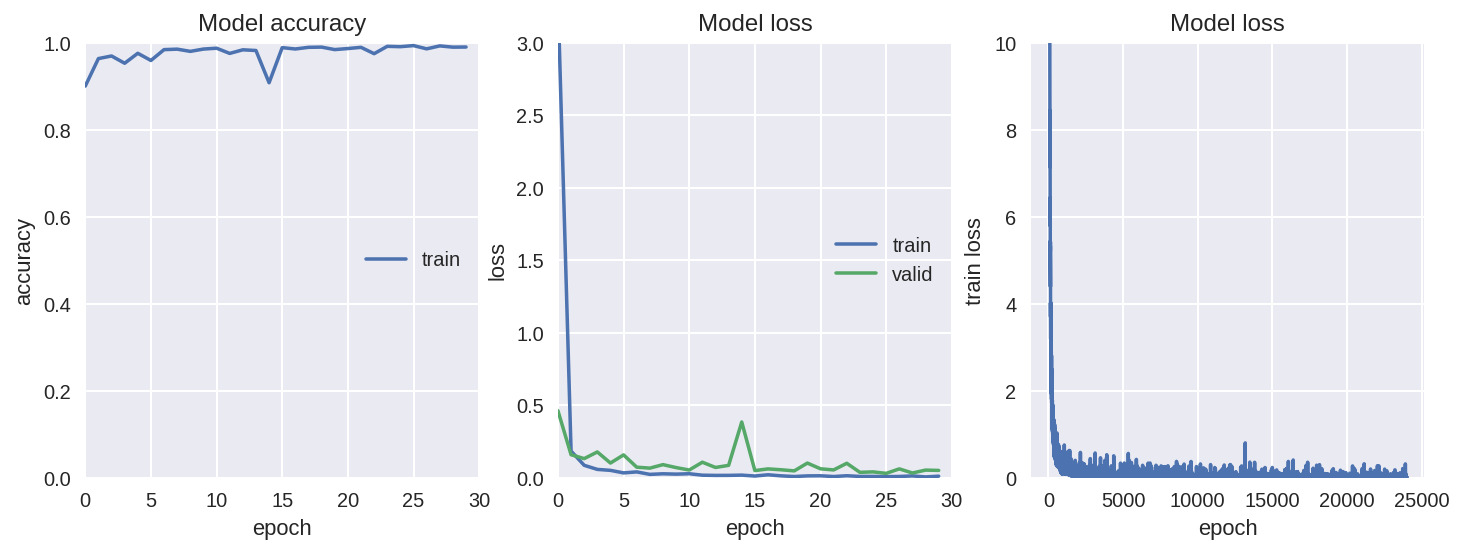

In [23]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

ax1.plot(valid_acc_callback.accs)
# ax1.plot(hist.history['val_acc'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_xlim(0, epoch_n)
ax1.set_ylim(0, 1)
ax1.set_title('Model accuracy')
ax1.legend(['train', 'valid'], loc='center right')

ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_xlim(0, epoch_n)
ax2.set_ylim(0, 3)
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model loss')
ax2.legend(['train', 'valid'], loc='center right')

ax3 = fig.add_subplot(133)
ax3.plot(valid_acc_callback.train_loss)
# ax3.set_xlim(0, epoch_n)
ax3.set_ylim(0, 10)
ax3.set_xlabel('epoch')
ax3.set_ylabel('train loss')
ax3.set_title('Model loss')
# ax3.legend(['train', 'valid'], loc='center right')

In [20]:
len(valid_acc_callback.train_loss)

24000

In [21]:
acc_test_generator = DataGenerator(test_X, test_y, img_width, img_height, img_channel, max_text_len, 16)
cb = MetricsCallback(model, acc_test_generator, test_y, 'test', True)
cb.validate()

625/625 [==============================] - 72s 115ms/step
val_loss.size:10000, mean:0.03957565873861313
pred_softmax.size: (10000, 19, 17)
test accuracy: 99.21%


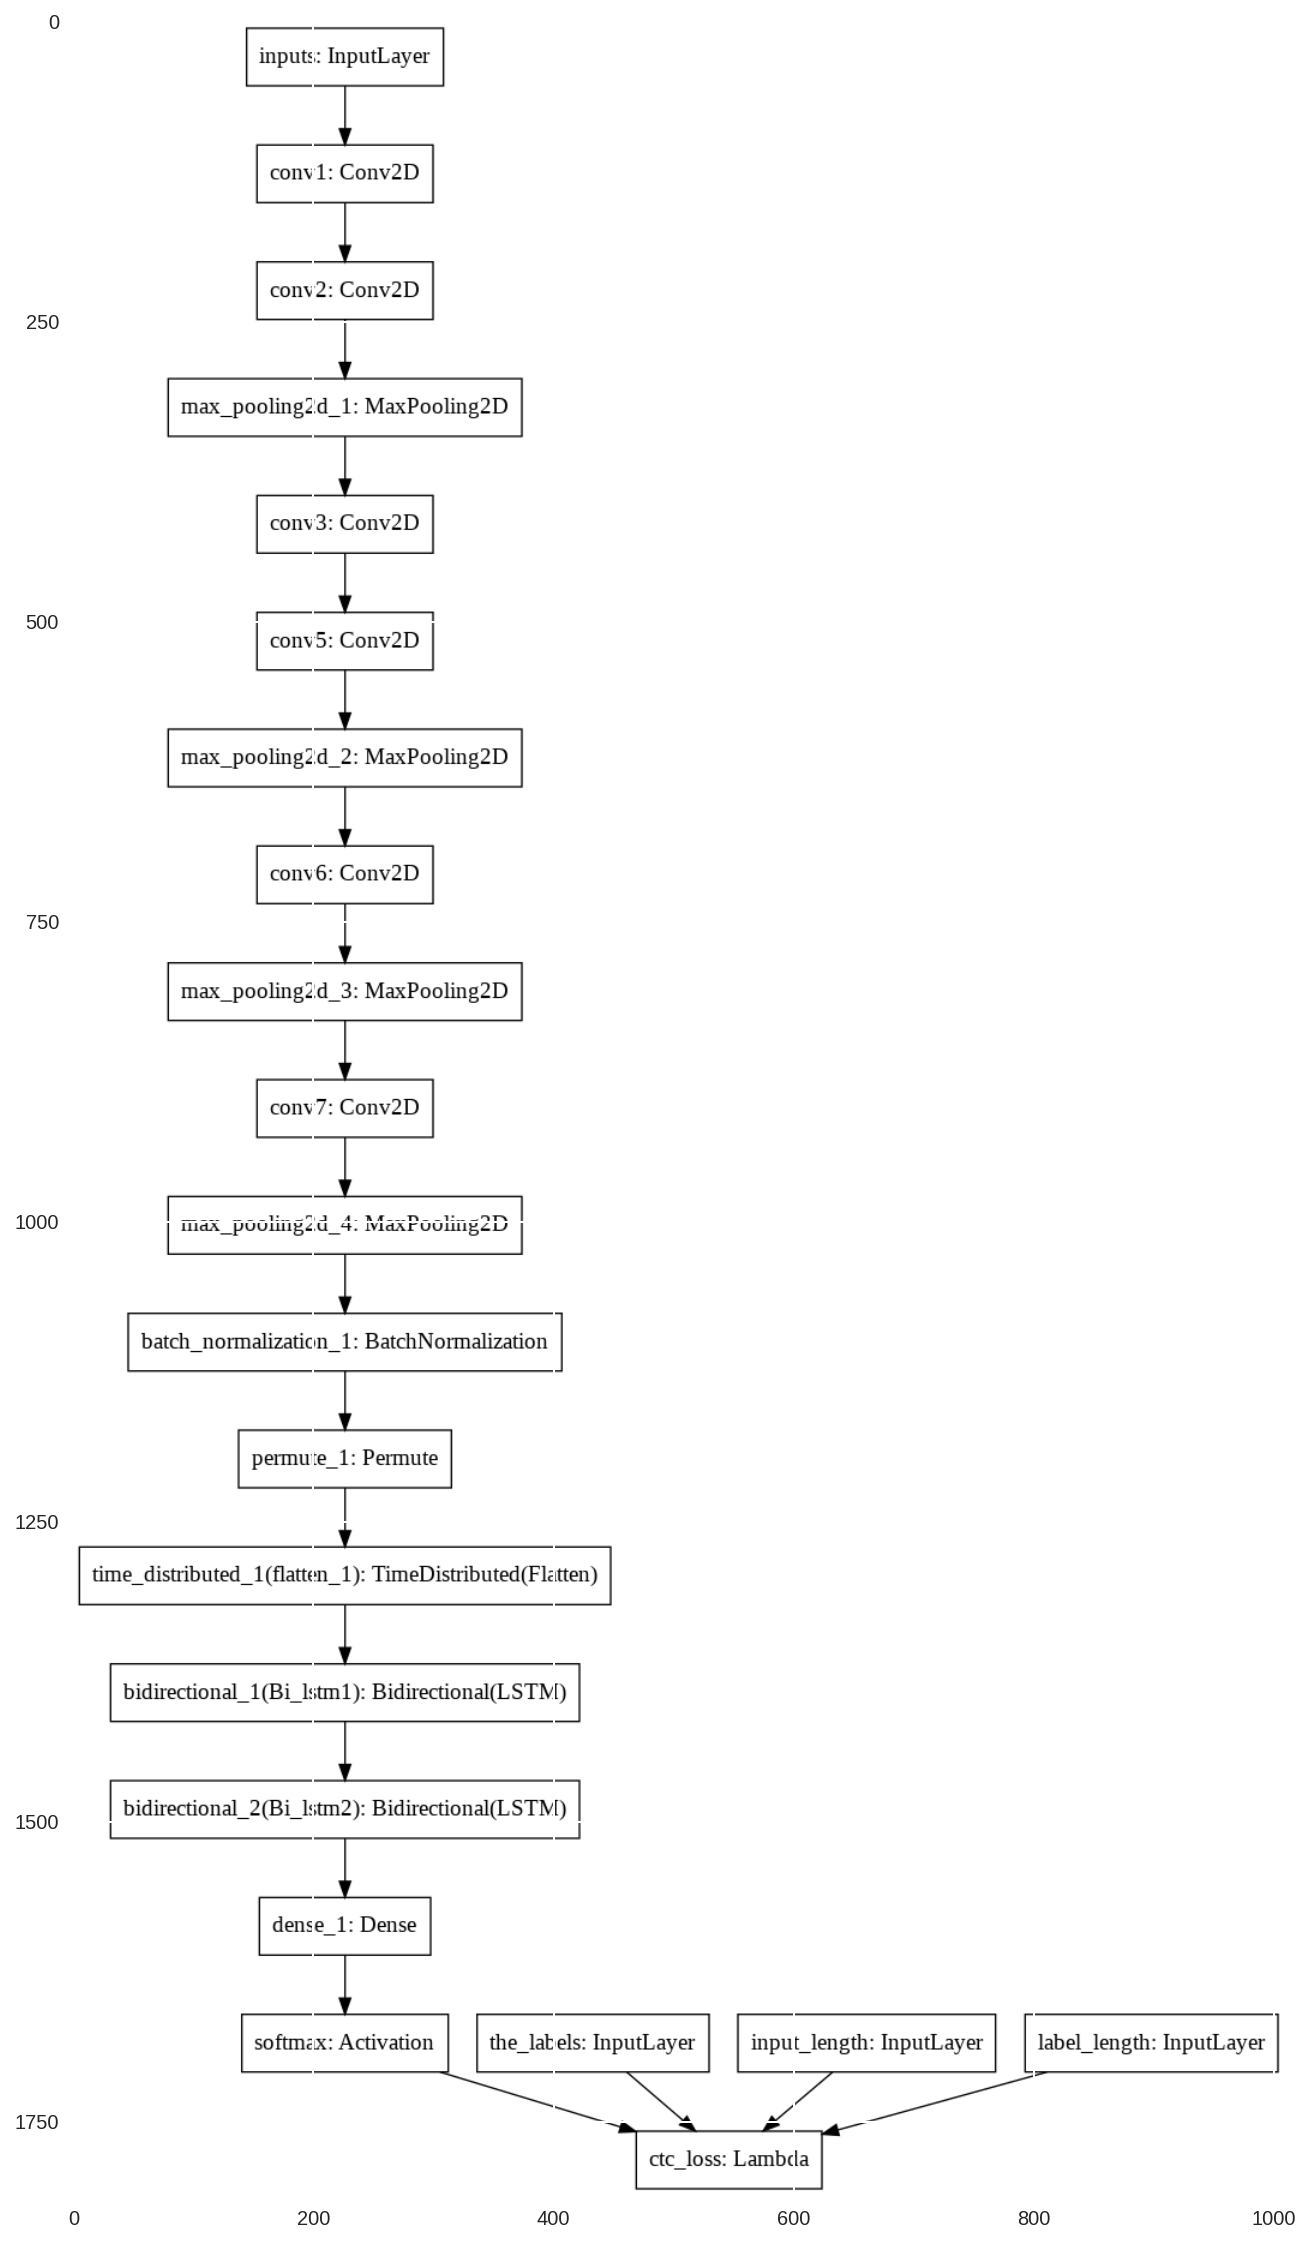

In [22]:
from keras.utils import plot_model

plot_model(model, to_file='my_crnn_model.png')

figure = plt.figure(figsize=(30, 20))
figure.add_subplot(111)
plt.imshow(plt.imread('my_crnn_model.png'), interpolation='bilinear')